In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/amazon-review-cleaned-labeled/amazon_reviews_cleaned_labeled_decreased_train (1).csv
/kaggle/input/amazon-review-cleaned-labeled/amazon_reviews_cleaned_labeled_decreased_test.csv
/kaggle/input/amazon-review-raw-cleaned-dataset/training_set_cleaned.csv
/kaggle/input/amazon-review-raw-cleaned-dataset/test_dataset_cleaned.csv


In [3]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.special import softmax

from tqdm.notebook import tqdm

# add this for pandas, to better look at the data
pd.set_option('display.max_columns', None)
pd.set_option('expand_frame_repr', False)

In [5]:
train_df = pd.read_csv('/kaggle/input/amazon-review-raw-cleaned-dataset/training_set_cleaned.csv')
test_df = pd.read_csv('/kaggle/input/amazon-review-raw-cleaned-dataset/test_dataset_cleaned.csv')

In [7]:
train_df['Sentiments'] = train_df['Sentiments'].astype(int)
test_df['Sentiments'] = test_df['Sentiments'].astype(int)


train_df['text'] = train_df['text'].astype(str).fillna('')
test_df['text'] = test_df['text'].astype(str).fillna('')

    labels                                               text
0        1  this is a great book i must preface this by sa...
1        0  huge disappointment as a big time long term tr...
2        1  wayne is tight but cant hang with turk this al...
3        1  excellent i read this book when i was in eleme...
4        0  not about anusara although this book is touted...
5        0  worst dvd ever purchased this was the very wor...
6        1  not the strongest fan but gets the job done i ...
7        0  bottom of the casebook barrel at the beginning...
8        1  hilarious this movie is very sweet i love it a...
9        0  the swinging sadly occurs only in the title sa...
10       1  planets my son loves it a hint of hanging this...
11       0  warning made in china i was just about to give...
12       0  didnt even work my little guy was highly dissa...
13       0  weak on content depth breadth editing cookbook...
14       0  just another guy who gave it star to bring dow...
15      

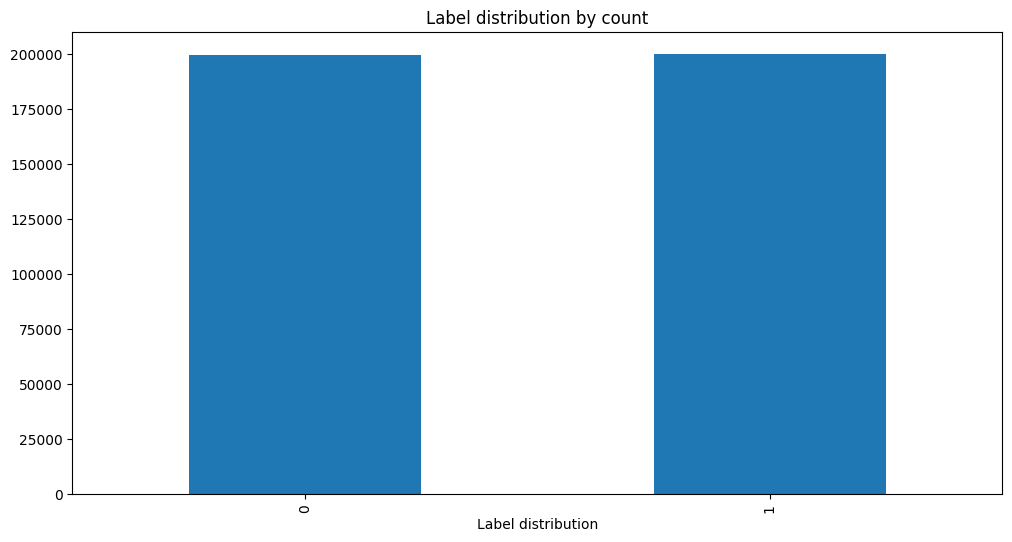

In [3]:
print(test_df.head(20))

print("the shape of the data", train_df.shape)

print("unique labels", train_df["labels"].unique())

valueCounts = train_df["labels"].value_counts().sort_index()
print(valueCounts)

ax = valueCounts.plot(kind="bar", title="Label distribution by count", figsize=(12, 6))
ax.set_xlabel("Label distribution")
plt.show()

In [13]:
train_df.shape , test_df.shape

((400000, 2), (50000, 2))

In [8]:
train_df = train_df.sample(n = 25000, random_state=42)
df_test = test_df.sample(n=7500, random_state=42)

In [6]:
import pandas as pd
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
import torch
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm
import time

In [11]:
import pandas as pd
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
import torch
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm
import time

def train_model(df, modelName, max_length=200, batch_size=8, learning_rate=2e-5, num_epochs=1, patience=3):
    # Split data into training and validation sets
    train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)
    
    # Load tokenizer
    tokenizer = DistilBertTokenizer.from_pretrained(modelName)

    # Load model
    model = DistilBertForSequenceClassification.from_pretrained(modelName)

    # Define optimizer and scheduler
    optimizer = AdamW(model.parameters(), lr=learning_rate)
    total_steps = len(train_df) // batch_size * num_epochs
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

    # Store accuracy for early stopping
    best_accuracy = 0
    patience_counter = 0

    # Lists to store accuracy values during training
    train_accuracy_list = []
    val_accuracy_list = []

    for epoch in range(num_epochs):
        start_time = time.time()
        print(f"Epoch {epoch + 1}/{num_epochs}")
        
        # Training loop
        model.train()
        train_accuracies = []
        for i, row in tqdm(enumerate(train_df.itertuples()), total=len(train_df)):
            text = row.text
            label = row.Sentiments

            # Tokenize input text
            inputs = tokenizer(text, return_tensors="pt", max_length=max_length, truncation=True, padding='max_length')

            # Forward pass
            outputs = model(**inputs)
            logits = outputs.logits

            # Compute loss and accuracy
            loss = F.cross_entropy(logits, torch.tensor([label]))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            scheduler.step()

            # Compute accuracy
            predictions = torch.argmax(logits, dim=1)
            accuracy = accuracy_score([label], [predictions.item()])
            train_accuracies.append(accuracy)

        # Validation loop
        model.eval()
        val_accuracies = []
        with torch.no_grad():
            for i, row in enumerate(val_df.itertuples()):
                text = row.text
                label = row.Sentiments

                # Tokenize input text
                inputs = tokenizer(text, return_tensors="pt", max_length=max_length, truncation=True, padding='max_length')

                # Forward pass
                outputs = model(**inputs)
                logits = outputs.logits

                # Compute accuracy
                predictions = torch.argmax(logits, dim=1)
                accuracy = accuracy_score([label], [predictions.item()])
                val_accuracies.append(accuracy)

        # Calculate average accuracy for the epoch
        avg_train_accuracy = np.mean(train_accuracies)
        avg_val_accuracy = np.mean(val_accuracies)

        # Append to accuracy lists
        train_accuracy_list.append(avg_train_accuracy)
        val_accuracy_list.append(avg_val_accuracy)

        # Print epoch statistics
        end_time = time.time()
        epoch_time = end_time - start_time
        print(f"Train Accuracy: {avg_train_accuracy}, Validation Accuracy: {avg_val_accuracy}, Time taken: {epoch_time:.2f} seconds")

        # Early stopping
        if avg_val_accuracy > best_accuracy:
            best_accuracy = avg_val_accuracy
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch + 1}")
                break

    # Plot accuracy curve
    plt.plot(train_accuracy_list, label='Train Accuracy')
    plt.plot(val_accuracy_list, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    return model, tokenizer, val_df

def evaluate_model(model, df_test, tokenizer, max_length=200):
    model.eval()
    predictions = []
    true_labels = []

    for row in df_test.itertuples():
        text = row.text
        label = row.Sentiments

        # Tokenize input text
        inputs = tokenizer(text, return_tensors="pt", max_length=max_length, truncation=True)

        # Forward pass
        with torch.no_grad():
            outputs = model(**inputs)
        
        # Compute predictions
        logits = outputs.logits
        predicted_label = torch.argmax(logits, dim=1).item()

        # Store predictions and true labels
        predictions.append(predicted_label)
        true_labels.append(label)

    # Calculate evaluation metrics
    print("Classification Report:")
    report = classification_report(true_labels, predictions, target_names=['Negative', 'Positive'])
    print(report)

    print("Confusion Matrix:")
    cm = confusion_matrix(true_labels, predictions)
    print(cm)

    # Plot confusion matrix heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix Heatmap')
    plt.show()


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/1


100%|██████████| 20000/20000 [1:02:06<00:00,  5.37it/s]


Train Accuracy: 0.8918, Validation Accuracy: 0.9008, Time taken: 3883.83 seconds


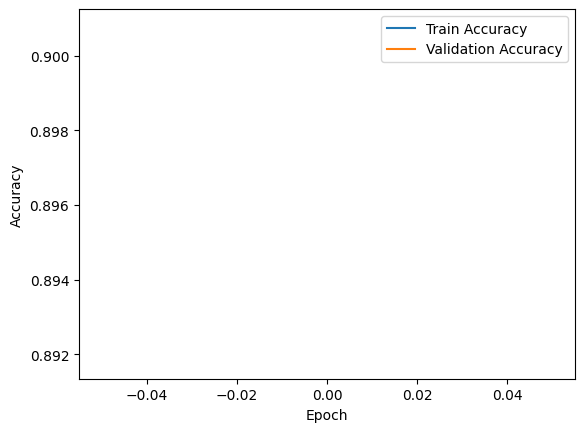

Classification Report:
              precision    recall  f1-score   support

    Negative       0.89      0.91      0.90      2508
    Positive       0.91      0.89      0.90      2492

    accuracy                           0.90      5000
   macro avg       0.90      0.90      0.90      5000
weighted avg       0.90      0.90      0.90      5000

Confusion Matrix:
[[2281  227]
 [ 269 2223]]


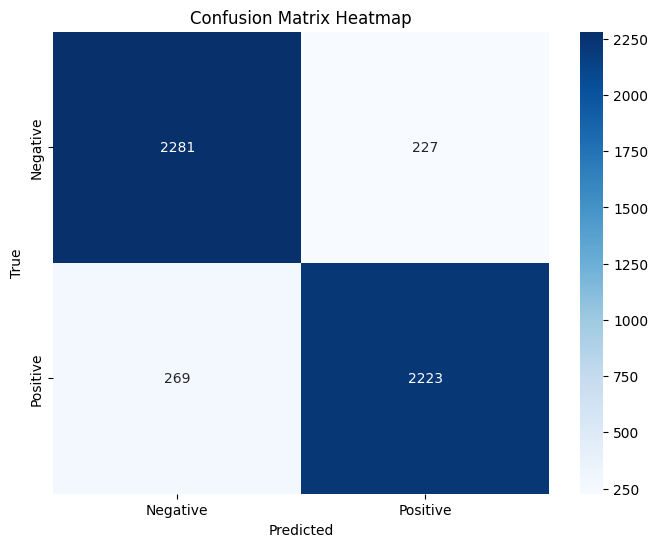

In [12]:
modelName = "distilbert-base-uncased"
#df = pd.read_csv("your_dataset.csv")  # Replace with your dataset
model, tokenizer, val_df = train_model(train_df, modelName)
evaluate_model(model, val_df, tokenizer)